<a href="https://colab.research.google.com/github/ahui-ops/road_to_pytorch2/blob/main/Simple_CNN(MNIST_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Convert MNIST image file into Tensor of 4-dim (nums of image, height, width, color channel)
transform = transforms.ToTensor()

In [7]:
# Train data
train_data = datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [8]:
# Test data
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)


In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
pwd

'/content'

In [11]:
# Create a small batch size of images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
# Define CNN model
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [13]:
# Grab 1 MNIST record
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [14]:
X_Train.shape

torch.Size([1, 28, 28])

In [15]:
x = X_Train.view(1,1,28,28)

In [16]:
# Perform first convolution
x = F.relu(conv1(x))

In [17]:
# 1 single image, 6 is the filters we asked for (26*26)
x.shape

torch.Size([1, 6, 26, 26])

In [18]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2)

In [19]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [20]:
# Do second convolutional layer
x = F.relu(conv2(x))

In [21]:
x.shape # Because no padding is set, so we will lose some pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [22]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [23]:
x.shape # round down 11/2 = 5

torch.Size([1, 16, 5, 5])

In [42]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolutional layer
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16,120) # torch.Size([1, 16, 5, 5])
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

    # Avoiding the model to "memorizing" instead of "thinking"
    self.dropout = nn.Dropout(p=0.4)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2*2 kernel and stride 2

    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2*2 kernel and stride 2

    # Re-View to flatten it out
    X = X.view(-1,16*5*5) # set -1 to vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = self.dropout(X)

    X = F.relu(self.fc2(X))
    X = self.dropout(X)

    X = self.fc3(X)
    return F.log_softmax(X,dim=1)


In [43]:
# Create an INstance of model
torch.manual_seed(32)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [44]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [45]:
import time
start_time = time.time()

# Create variables to track things
epoch = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Create for loops for epochs
for i in range(epoch):
  trn_corr = 0
  tst_corr = 0
  trn_loss = 0
  tst_loss = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start batches at 1
    y_pred = model(X_train) #get predicted values from the training set (2-dim)
    loss = criterion(y_pred, y_train) # calculate loss

    trn_loss += loss.item()

    predicted = torch.max(y_pred.data,1)[1] # add up the num of correct predictions. (exclude the first point)
    batch_corr = (predicted == y_train).sum() # how many correct frm the specific batch
    trn_corr += batch_corr

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out some results
    if b%600 == 0:
      print(f"Epoch: {i}  Batch: {b}  Loss: {loss.item()}")

  train_losses.append(trn_loss/b)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biasses with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      b+=1
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1] # add up correct prediction
      tst_corr += (predicted == y_test).sum()
      loss = criterion(y_val, y_test)
      tst_loss += loss.item()

  test_losses.append(tst_loss/b)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"training took: {total/60}minutes")

Epoch: 0  Batch: 600  Loss: 0.25098681449890137
Epoch: 0  Batch: 1200  Loss: 0.4828811287879944
Epoch: 0  Batch: 1800  Loss: 0.053486693650484085
Epoch: 0  Batch: 2400  Loss: 0.10787037760019302
Epoch: 0  Batch: 3000  Loss: 0.3833278715610504
Epoch: 0  Batch: 3600  Loss: 0.05356200784444809
Epoch: 0  Batch: 4200  Loss: 0.09401733428239822
Epoch: 0  Batch: 4800  Loss: 0.12405748665332794
Epoch: 0  Batch: 5400  Loss: 0.5969054698944092
Epoch: 0  Batch: 6000  Loss: 0.004344828426837921
Epoch: 1  Batch: 600  Loss: 0.06427505612373352
Epoch: 1  Batch: 1200  Loss: 0.06448914110660553
Epoch: 1  Batch: 1800  Loss: 0.29361000657081604
Epoch: 1  Batch: 2400  Loss: 0.40580815076828003
Epoch: 1  Batch: 3000  Loss: 0.008609902113676071
Epoch: 1  Batch: 3600  Loss: 0.010365256108343601
Epoch: 1  Batch: 4200  Loss: 0.07903037965297699
Epoch: 1  Batch: 4800  Loss: 0.20745150744915009
Epoch: 1  Batch: 5400  Loss: 0.009272631257772446
Epoch: 1  Batch: 6000  Loss: 0.11968378722667694
Epoch: 2  Batch: 600

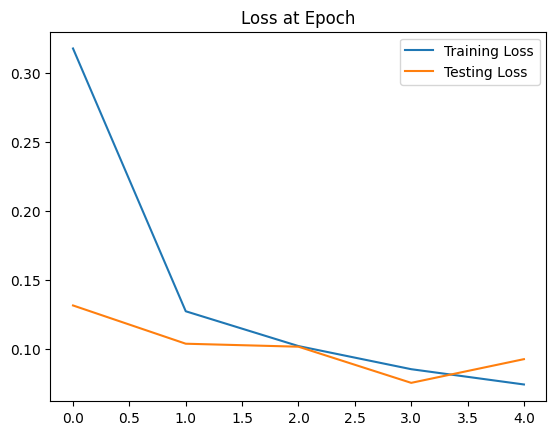

In [46]:
# Graph the loss at label
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Testing Loss")
plt.title("Loss at Epoch")
plt.legend()

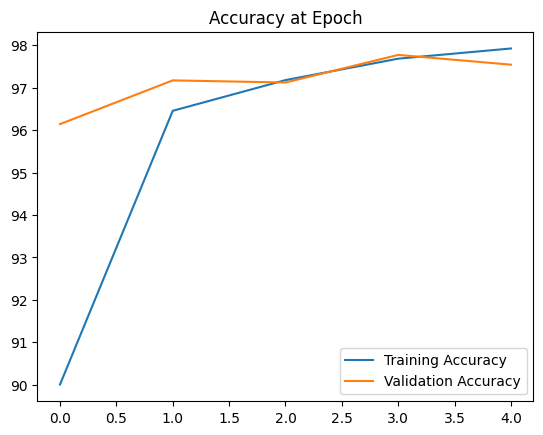

In [47]:
# graph the accuracy of the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at Epoch")
plt.legend()

In [48]:
test_load_everything = DataLoader(test_data,batch_size=10000, shuffle=False)

In [50]:
with torch.no_grad():
  correct=0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [53]:
correct.item()/len(test_data)*100

97.58

In [55]:
# Grab an image
test_data[4143] # tensor with an image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [57]:
# grab the data
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [58]:
# Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

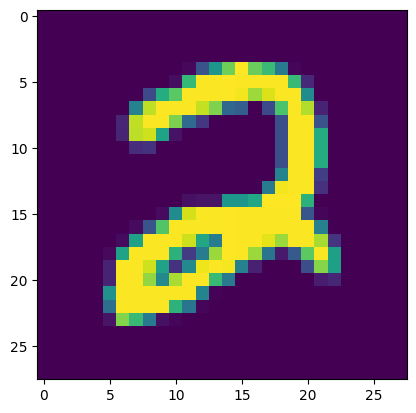

In [65]:
# Show the image
plt.imshow(test_data[3628][0].reshape(28,28))

In [66]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_predict = model(test_data[3628][0].view(1,1,28,28)) # batch size = 1, color channel =1, 28*28 image

new_predict

tensor([[-31.6041, -23.6311,   0.0000, -19.8643, -34.6460, -42.8554, -38.2684,
         -25.7090, -23.6869, -35.2235]])

In [67]:
new_predict.argmax()

tensor(2)